In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import csv
from tensorflow.keras.preprocessing.image import load_img, img_to_array

img_size = 224

In [2]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, BinaryCrossentropy, Huber
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from keras.api._v2.keras import activations
from keras.callbacks import Callback, ModelCheckpoint

def build_model():
    shape = (img_size, img_size, 3)
    input_layer = Input(shape = shape)

    #Fine tuning did not show any significant improvement
    vgg = VGG16(include_top = False, weights='imagenet')
    for layer in vgg.layers:
        layer.trainable = False

    vgg           = vgg(input_layer)
    batch         = BatchNormalization()(vgg)
    globalPooling = GlobalAveragePooling2D()(batch)

    #Dense Layer 1
    dropout1 = Dropout(0.15, seed=2910)(globalPooling)
    dense1   = Dense(512, activation='elu')(dropout1)
    norm1    = BatchNormalization()(dense1)
    #Dense Layer 2
    dropout2 = Dropout(0.15, seed=2003)(norm1)
    dense2   = Dense(256, activation='elu')(dropout2)
    norm2    = BatchNormalization()(dense2)
    #Dense Layer 3
    dropout3 = Dropout(0.15, seed=2017)(norm2)
    dense3   = Dense(128, activation='elu')(dropout3)
    norm3    = BatchNormalization()(dense3)
    #Dense Layer 4
    dropout4           = Dropout(0.15, seed=2905)(norm3)
    dense4             = Dense(32, activation='elu')(dropout4)
    final_dense_shared = BatchNormalization()(dense4)

    # Eye identification
    eye = Dense(1, activation = "sigmoid", name='eye')(final_dense_shared)

    # Gender identification
    gender = Dense(1, activation = "sigmoid", name='gender')(final_dense_shared)

    # Race
    race = Dense(4, activation='softmax', name='race')(final_dense_shared)

    # Contacts
    contacts = Dense(3, activation='softmax', name='contacts')(final_dense_shared)

    # Position and radius of the pupil
    position_and_radius = Dense(3, name="position_and_radius")(final_dense_shared)

    new_model = Model(inputs = input_layer, outputs = [eye, gender, race, contacts, position_and_radius])

    return new_model

model = build_model()

optimizer = Adam(learning_rate = 0.001)

losses = {
    'eye': BinaryCrossentropy(),
    'gender': BinaryCrossentropy(),
    'race': SparseCategoricalCrossentropy(),
    'contacts': SparseCategoricalCrossentropy(),
    'position_and_radius': Huber(delta=0.125)
}

metrics = {
    'eye': 'accuracy',
    'gender': 'accuracy',
    'race': 'accuracy',
    'contacts': 'accuracy',
}

model.compile(optimizer = optimizer, loss = losses, metrics=metrics)

In [3]:
model.load_weights("Labels_and_pupil_identification_weights.h5")

In [4]:
import matplotlib.patches as patches
from matplotlib import cm
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
import time
import random

In [5]:
def process_output(output):
    eye_labels = {0: 'Left', 1: 'Right'}
    gender_labels = {0: 'Male', 1: 'Female'}
    race_labels = {0: 'Asian', 1: 'Black', 2: 'Other', 3: 'White'}
    contact_labels = {0: 'Cosmetic', 1: 'No', 2: 'Yes'}

    eye_result = eye_labels[int(round(output[0][0][0]))]
    gender_result = gender_labels[int(round(output[1][0][0]))]
    race_result = race_labels[np.argmax(output[2][0])]
    contact_result = contact_labels[np.argmax(output[3][0])]

    return [eye_result, gender_result, race_result, contact_result]


def show_image_with_circle(image_array, x_center, y_center, radius):
    # Make a copy of the input image to avoid modifying the original
    image_with_circle = np.copy(image_array)

    # Ensure the circle coordinates and radius are within the image dimensions
    x_center = int(np.clip(x_center, 0, image_with_circle.shape[1] - 1))
    y_center = int(np.clip(y_center, 0, image_with_circle.shape[0] - 1))
    radius = int(radius)

    # Draw the circle on the image
    color = (1, 0, 0)
    linewidth = 2  # Line width of the circle
    plt.imshow(image_with_circle)

    # Create a Circle patch for the circle
    circle = Circle((x_center, y_center), radius, fill=False, edgecolor=color, linewidth=linewidth)

    # Add the circle to the current axis
    plt.gca().add_patch(circle)

    plt.show()

1/1 [==============================] - 0s 243ms/step
List of predictions: Left or right eye; Gender; Race; Contacts
Model prediction:  ['Left', 'Female', 'White', 'Yes']


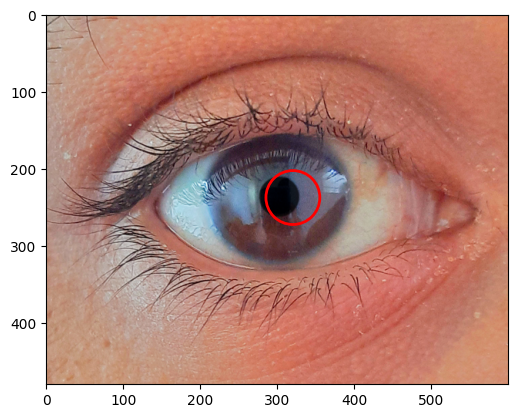

In [19]:
path = r"C:\Users\mathe\OneDrive\Área de Trabalho\t2.tif"

img = img_to_array(load_img(path)) / 255. #This is the image that will be shown

img_prediction = img_to_array(load_img(path, target_size=(img_size,img_size))) / 255. #This is the image that will go to the NN
temp = np.array([img_prediction])

predicao = (model.predict(temp))

print("List of predictions: Left or right eye; Gender; Race; Contacts")
print("Model prediction: ",process_output(predicao))

position = predicao[4][0]
x = position[0]
y = position[1]
radius = position[2]

show_image_with_circle(img, x, y, radius)